# Rescanning

We ask if you make *TWO* measurements of duration $T$, separated by a time $T_{\rm wait}$ what is the resulting distribution of $\langle \cos^2{\theta}\rangle_{2T}$?

We display this in terms of the 5th percentile of $\langle \cos^2{\theta}\rangle_{2T}$, as in the other plots. And also show some contours to show how much $\langle \cos^2{\theta}\rangle_{2T}$ improves upon the single measurement result $\langle \cos^2{\theta}\rangle_{T}$

In [1]:
from numpy import *
from PlotFuncs import *
from LabFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit,njit,prange
from numpy import random
from scipy.integrate import cumtrapz
from tqdm import tqdm


from scipy.special import erf
from scipy.optimize import fsolve

def ConversionFactors(costh_samples,nbins=1000):
    h,ce = histogram(costh_samples,nbins)
    cc = (ce[1:]+ce[0:-1])/2
    
    P_costh = h/sum(h) 
    
    fs = lambda P0 : 0.05-sum(0.5*(1+erf(-P0*cc/sqrt(2)))*P_costh)
    res = fsolve(fs,1.64*3)
    cval_excl = 1.64/res
    
    fs = lambda P0 : 0.05-sum(0.5*(1+erf((5-P0*cc)/sqrt(2)))*P_costh)
    res = fsolve(fs,1.64*3+5)
    cval_disc = (5+1.64)/res
    return cval_excl,cval_disc

@jit(nopython=True)
def costh_T(fcosth2,lat,DT,T,costh_X,phi_X): 
    '''
    This function calculates <cos^2(th)>_T for an array of T
    I have sped up the calculaton by calculating cos(th) at 
    increasing values of T and then doing a cumulative average over
    the resulting array at the end
    INPUT: 
    costh_X,phi_X = the DP polarisation axes (size=ngen)
    fcosth2 = the function name of the relevant angle, e.g. costh2N, costh2W, costh2Z
    DT = a single time used to add to the array of values of T
    T = measurement times (size=nt)
    lat = latitude in degrees
    OUTPUT:
    c_av = <cos^2(th)>T for each input T (size=nt)
    '''
    ngen = len(costh_X)
    nt = len(T)-1
    c1t = zeros(shape=(ngen,nt+1))

    for i in range(0,nt+1):
        c1t[:,i] = fcosth2(T[i]+DT,costh_X,phi_X,lat)

    c_av = zeros(shape=(ngen,nt))
    for i in range(0,ngen):
        c_av[i,:] = 0.5*(c1t[i,1:]+c1t[i,0:-1])*(T[1:]-T[0:-1])
        c_av[i,:] = cumsum(c_av[i,:])/T[1:]
    return c_av

def costh_av_Rescan_dist(dTvals,DTvals,fcosth2,lat,ngen=100000):
    '''
    This function creates an array of values of <cos^2(th)>(3T)^{95%}
    for an array of T and an array of T_wait
    It assumes we make THREE measurements of duration T
    INPUT:
    dTvals = array of T (size=n1)
    DTvals = array of T_wait (size=n2)
    fcosth2 = the function name of the relevant angle, e.g. costh2N, costh2W, costh2Z
    
    OUTPUT:
    C = array of <cos^2(th)>(3T)^{95%} (size=(n1,n2))
    C_enhancement = array of <cos^2(th)>(3T)^{95%}/array of <cos^2(th)>(T)^{95%}(size=(n1,n2)))
    ''' 
    costh_X = 2*random.uniform(size=ngen)-1.0
    phi_X = 2*pi*random.uniform(size=ngen)


    n1 = len(DTvals)
    n2 = len(dTvals)-1
    c_av0 = costh_T(fcosth2,lat,0,dTvals,costh_X,phi_X)
    C0 = zeros(shape=n2)
    for i in range(0,n2):
        _,C0[i] = ConversionFactors(c_av0[:,i])
    
    
    C = zeros(shape=(n1,n2))
    C_enhancement = zeros(shape=(n1,n2))
    for i in tqdm(range(0,n1)):
        c_av1 = costh_T(fcosth2,lat,DTvals[i],dTvals,costh_X,phi_X)
        
        c_av = 0.5*(c_av0+c_av1)
        for j in range(0,n2):
            _,C[i,j] = ConversionFactors(c_av[:,j])
            
        C_enhancement[i,:] = C[i,:]/C0
    return C,C_enhancement

n1 = 200
n2 = 200
DTvals = linspace(0.01,1.0,n1)
dTvals = logspace(log10(1e-3),log10(5.0),n2+1)

CN,CN_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2N,55)
CW,CW_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2W,35)
CZ,CZ_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2Z,35)

CZW,CZW_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2ZW,55)
CZN,CZN_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2ZN,35)
CNW,CNW_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2NW,35)

  9%|▉         | 18/200 [00:30<05:02,  1.66s/it]/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
  7%|▋         | 14/200 [00:25<05:35,  1.80s/it]/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
  9%|▉         | 18/200 [00:30<04:59,  1.65s/it]/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 200/200 [05:42<00:00,  1.71s/it]


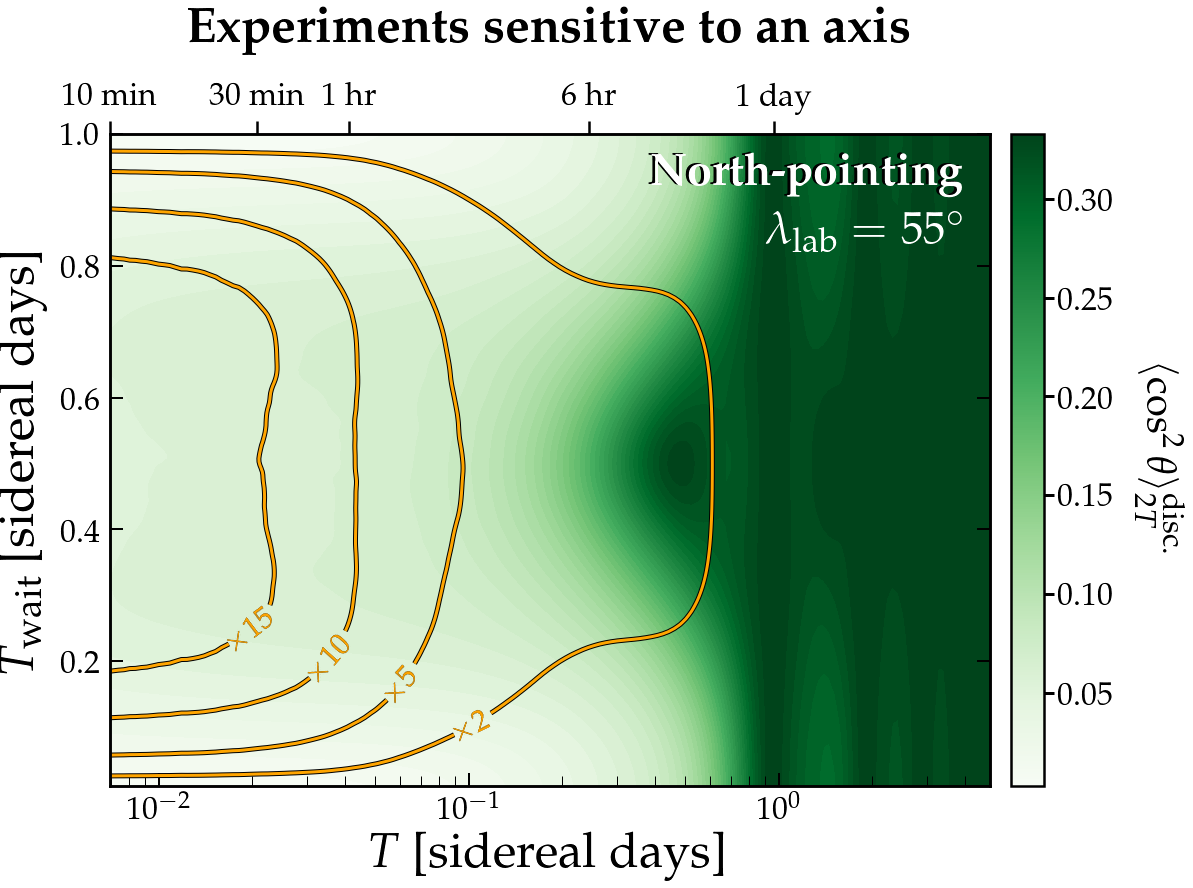

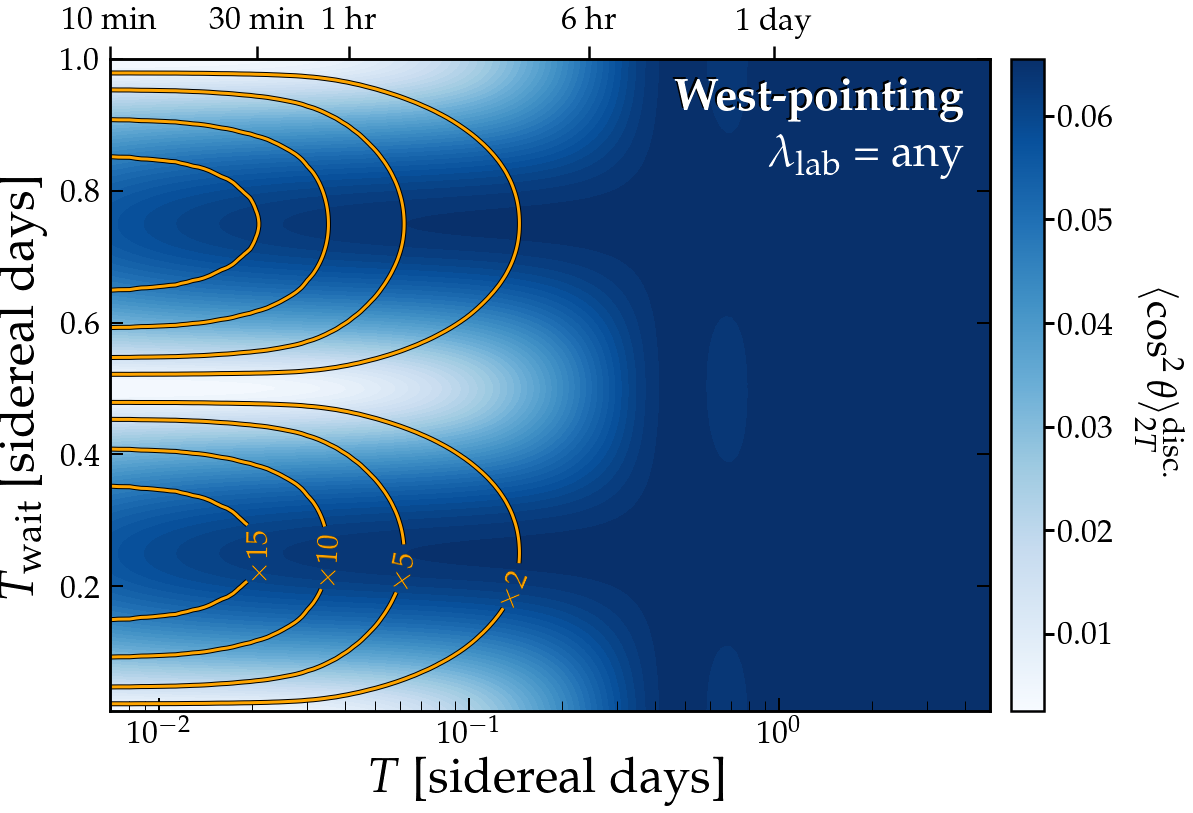

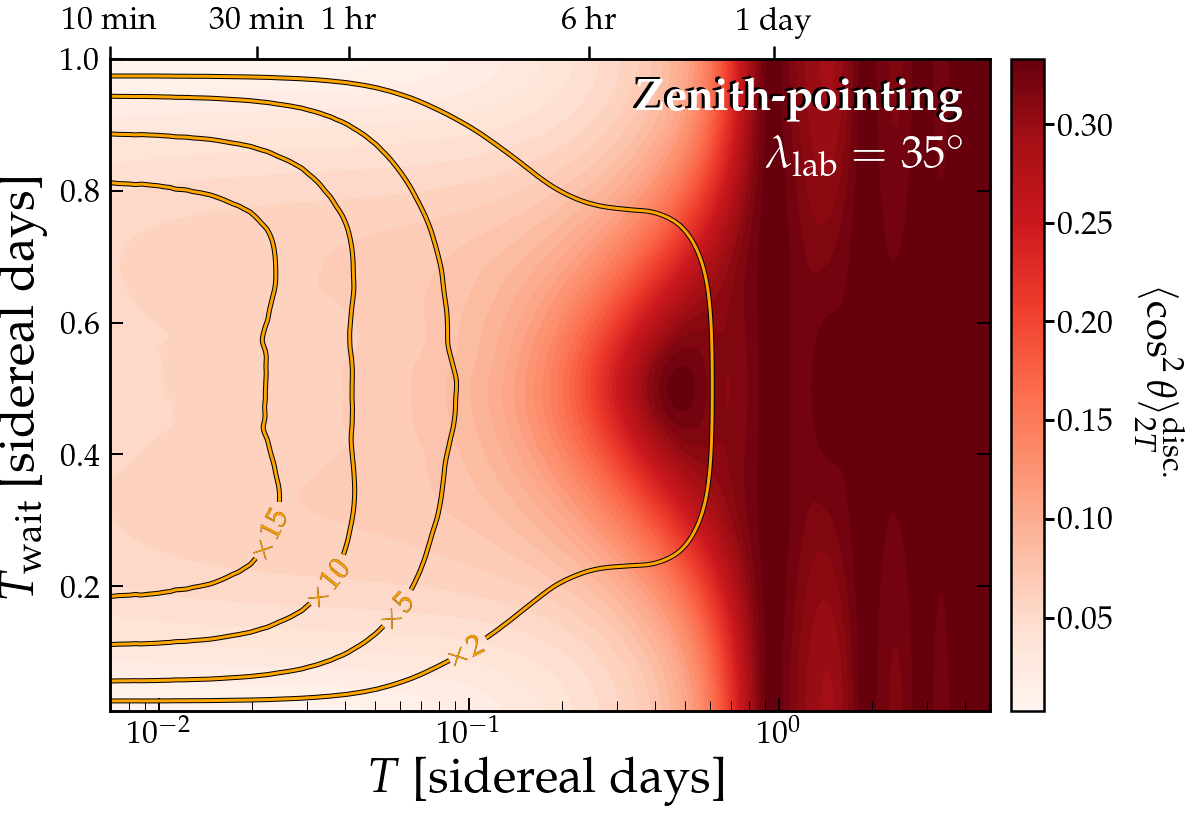

In [5]:
import matplotlib.colors as colors
import matplotlib.patheffects as pe
pek=[pe.Stroke(linewidth=5, foreground='k',alpha=1), pe.Normal()]

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"$\times${s}"

def Plot_costh_Rescan(C,C_enhancement,levels,clab_loc,cmap,cont_col,axis_lab,lat_lab,cbar_lab):
    fig,ax = MySquarePlot(r'$T$ [sidereal days]',r'$T_{\rm wait}$ [sidereal days]',size_x=19,tfs=32,lfs=49)
    ax.tick_params(pad=10)
    
    ax.set_xscale('log')
    ax.set_xlim([10/(24*60),dTvals[-2]])
    ax2 = ax.twiny()
    ax2.set_xscale('log')
    ax2.set_xlim([10/(24*60),dTvals[-1]])
    ax2.set_xticks([10/(24*60),30/(24*60),1/24,6/24,1])
    ax2.set_xticklabels(['10 min','30 min','1 hr','6 hr','1 day'])
    ax2.minorticks_off()
    ax2.tick_params(which='major',direction='out',width=2.5,length=13,pad=7)

    plt.sca(ax)
    im = ax.pcolormesh(dTvals[0:-1],DTvals,C,cmap=cmap,vmin=0.0025,vmax=amax(C),rasterized=True)
    ax.contourf(dTvals[0:-1],DTvals,C,cmap=cmap,levels=50,vmin=0.0025,vmax=amax(C))
    CS1 = ax.contour(dTvals[0:-1],DTvals,C_enhancement,levels=levels,colors=['k'],linewidths=5)
    CS = ax.contour(dTvals[0:-1],DTvals,C_enhancement,levels=levels,colors=[cont_col],linewidths=3)
    plt.plot([],[],'-',color=cont_col,lw=3,label='Enhancement',path_effects=pek)
    ax.clabel(CS1, CS1.levels, inline=True, fmt=fmt,fontsize=30,manual=clab_loc)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt,fontsize=30,manual=clab_loc)

    #plt.legend(framealpha=1,loc='lower right')
    cbar1 = plt.colorbar(im,pad=0.02)
    cbar1.ax.tick_params(which='minor',length=8,width=2)
    cbar1.ax.tick_params(which='major',length=10,width=3)
    cbar1.set_label(cbar_lab,fontsize=40,rotation=-90,labelpad=60)

    plt.gcf().text(0.748,0.822,axis_lab,fontsize=45,ha='right',color='k')
    plt.gcf().text(0.75,0.82,axis_lab,fontsize=45,ha='right',color='w')
    plt.gcf().text(0.75,0.745,lat_lab,fontsize=45,ha='right',color='w')
    plt.gcf().text(0.9,0.5,'--',zorder=-100,color='w')
    return fig,ax

cbar_lab = r'$\langle \cos^2\theta \rangle_{2T}^{\rm disc.}$'

levels1 = [2,5,10,15]
clab_loc1 = [(0.016, 0.32), (0.035, 0.21), (0.06, 0.17), (0.11, 0.07)]
axis_lab1 = r'{\bf North-pointing}'
lat_lab1 = r'$\lambda_{\rm lab} = '+str(int(55))+r'^\circ$'

levels2 = [2,5,10,15]
clab_loc2 = [(0.022, 0.25), (0.04, 0.24), (0.07, 0.22), (0.2, 0.16)]
axis_lab2 = r'{\bf West-pointing}'
lat_lab2 = r'$\lambda_{\rm lab}$ = {\rm any}'

levels3 = [2,5,10,15]
clab_loc3 = [(0.0175, 0.31), (0.035, 0.21), (0.07, 0.13), (0.1, 0.1)]
axis_lab3 = r'{\bf Zenith-pointing}'
lat_lab3 = r'$\lambda_{\rm lab} = '+str(int(35))+r'^\circ$'

fig1,ax1 = Plot_costh_Rescan(CN,CN_enhancement,levels1,clab_loc1,cm.Greens,'orange',axis_lab1,lat_lab1,cbar_lab)
plt.title(r'{\bf Experiments sensitive to an axis}',fontsize=50,pad=40)

fig2,ax2 = Plot_costh_Rescan(CW,CW_enhancement,levels2,clab_loc2,cm.Blues,'orange',axis_lab2,lat_lab2,cbar_lab)
fig3,ax3 = Plot_costh_Rescan(CZ,CZ_enhancement,levels3,clab_loc3,cm.Reds,'orange',axis_lab3,lat_lab3,cbar_lab)

MySaveFig(fig1,'Rescan_North')
MySaveFig(fig2,'Rescan_West')
MySaveFig(fig3,'Rescan_Zenith')

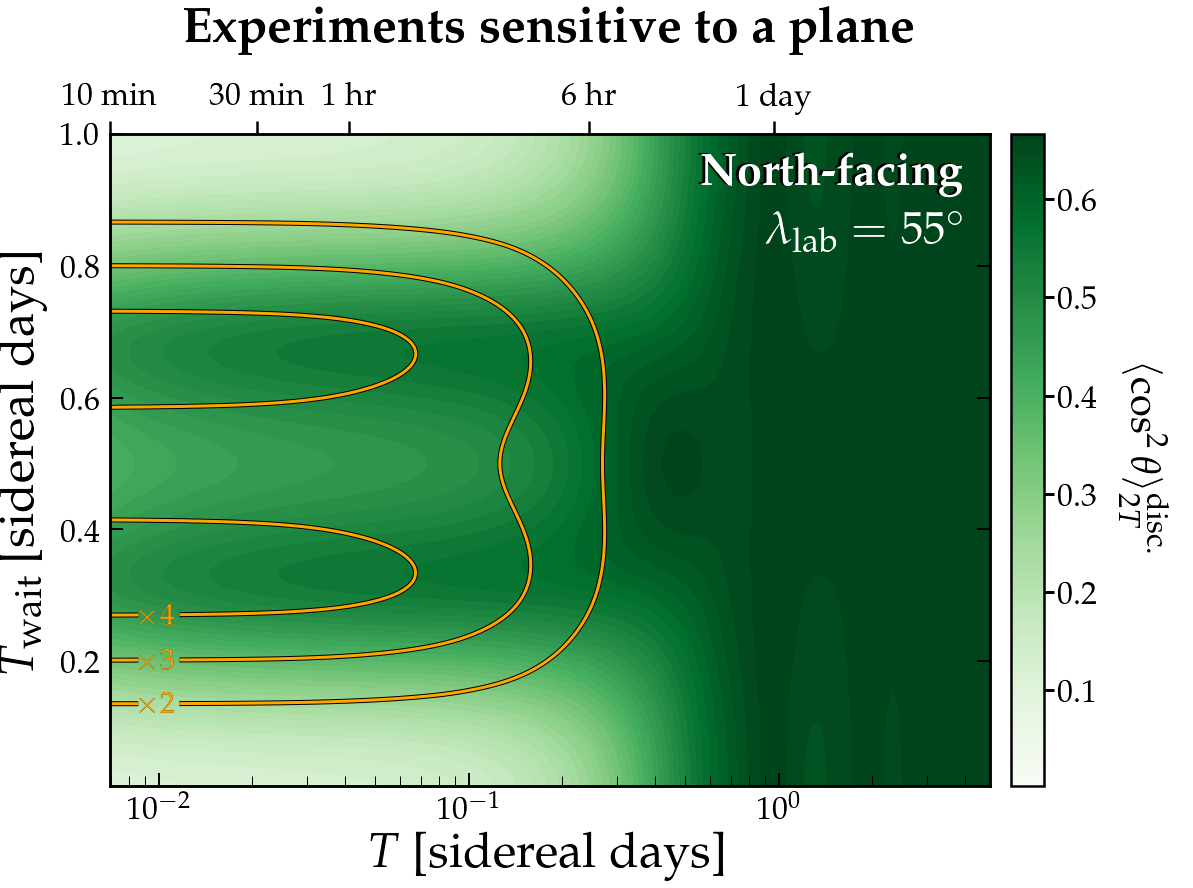

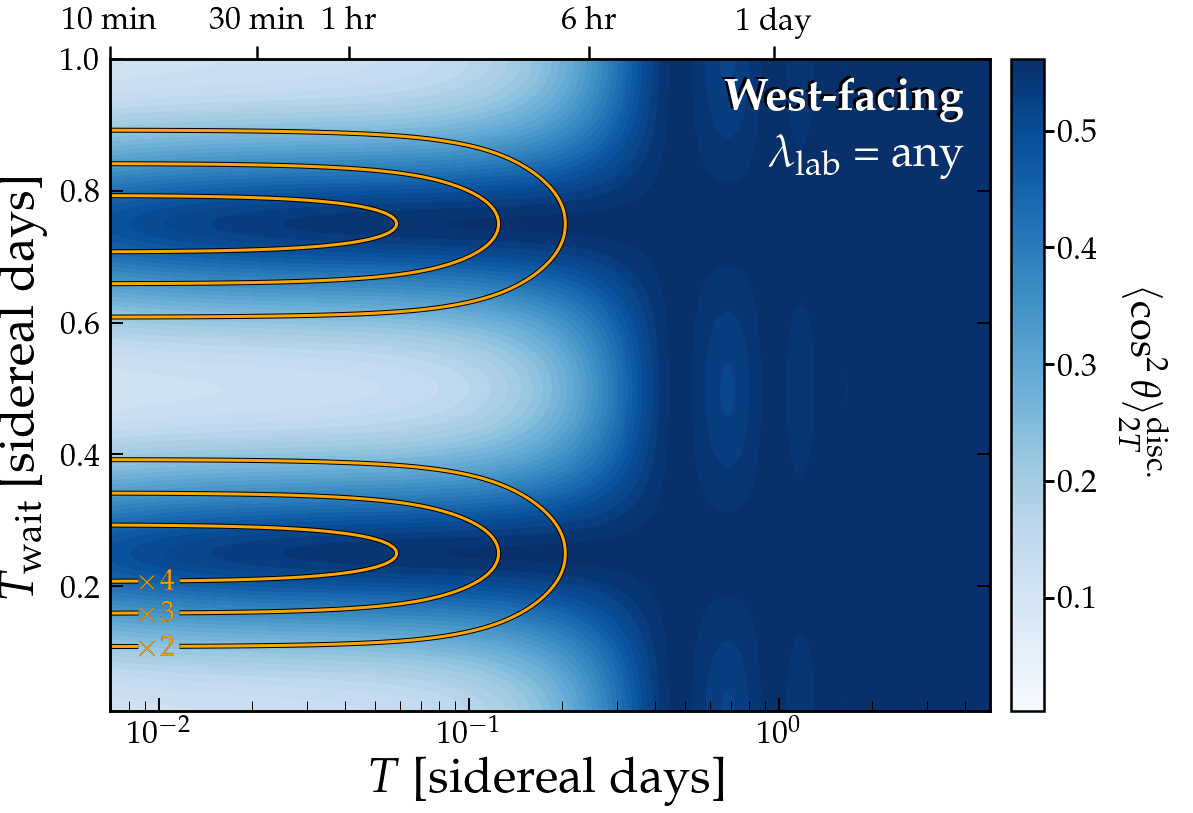

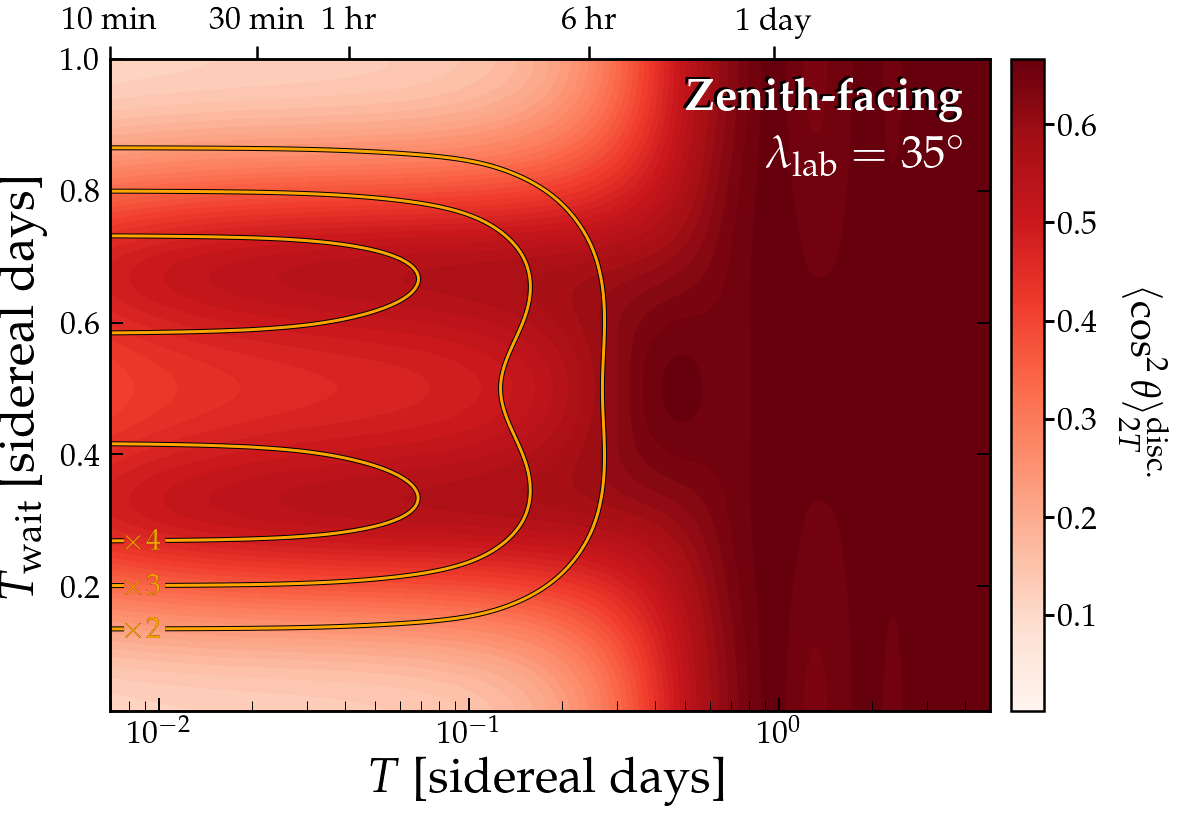

In [6]:
cbar_lab = r'$\langle \cos^2\theta \rangle_{2T}^{\rm disc.}$'


levels1 = [2,3,4]
clab_loc1 = [(0.01, 0.32), (0.01, 0.18), (0.01, 0.1)]
axis_lab1 = r'{\bf North-facing}'
lat_lab1 = r'$\lambda_{\rm lab} = '+str(int(55))+r'^\circ$'

levels2 = [2,3,4]
clab_loc2 = [(0.01, 0.25), (0.01, 0.18), (0.01, 0.1)]
axis_lab2 = r'{\bf West-facing}'
lat_lab2 = r'$\lambda_{\rm lab}$ = {\rm any}'

levels3 = [2,3,4]
clab_loc3 = [(0.009, 0.32), (0.009, 0.18), (0.009, 0.1)]
axis_lab3 = r'{\bf Zenith-facing}'
lat_lab3 = r'$\lambda_{\rm lab} = '+str(int(35))+r'^\circ$'


fig1,ax1 = Plot_costh_Rescan(CZW,CZW_enhancement,levels1,clab_loc1,cm.Greens,'orange',axis_lab1,lat_lab1,cbar_lab)
plt.title(r'{\bf Experiments sensitive to a plane}',fontsize=50,pad=40)

fig2,ax2 = Plot_costh_Rescan(CZN,CZN_enhancement,levels2,clab_loc2,cm.Blues,'orange',axis_lab2,lat_lab2,cbar_lab)
fig3,ax3 = Plot_costh_Rescan(CNW,CNW_enhancement,levels3,clab_loc3,cm.Reds,'orange',axis_lab3,lat_lab3,cbar_lab)

MySaveFig(fig1,'Rescan_NorthFacing')
MySaveFig(fig2,'Rescan_WestFacing')
MySaveFig(fig3,'Rescan_ZenithFacing')